In [1]:
#%pip install sae_lens
#%pip install transformer_lens
import einops
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
from transformers import AutoModel, AutoTokenizer
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import numpy as np
import torch as t
import plotly_express as px
import matplotlib.pyplot as plt
import matplotlib as mpl

from transformer_lens import HookedTransformer
from transformer_lens.utils import (
    load_dataset,
    tokenize_and_concatenate,
    download_file_from_hf,
)
device = t.device("cuda" if t.cuda.is_available() else "cpu")
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling

In [2]:
# Load LLM and SAE
model = HookedTransformer.from_pretrained("gpt2-small").to(device)
hook_point = 'blocks.6.hook_resid_pre'
gpt2_small_sparse_autoencoder, sparsities = get_gpt2_res_jb_saes(hook_point=hook_point, device='cpu')
gpt2_small_sparse_autoencoder = gpt2_small_sparse_autoencoder[hook_point]

/home/codespace/.python/current/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


In [3]:
# Load in a random set of features.
k = 1000
t.manual_seed(42)
perm = t.randperm(gpt2_small_sparse_autoencoder.W_dec.shape[0])
random_idx = perm[:k]


with t.no_grad():    
  dec = gpt2_small_sparse_autoencoder.W_dec[random_idx,:]
  dot_prods_resid = einops.einsum(dec, dec, 'feature1 resid , feature2 resid  -> feature1 feature2')
  idx = t.tril_indices(dot_prods_resid.shape[0], dot_prods_resid.shape[1], offset=-1)
  # Get the elements of cosine at idx
  dot_prods_resid = dot_prods_resid[idx[0,:], idx[1,:]]
  del idx

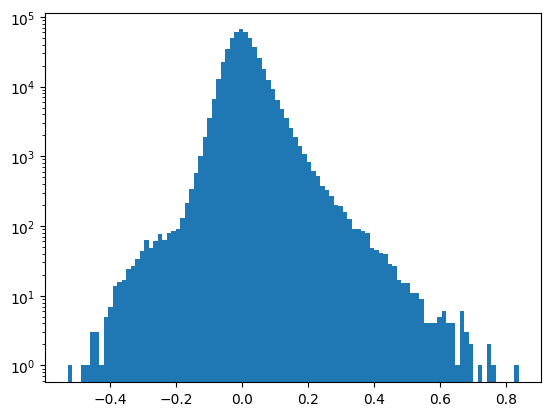

In [4]:
# Plot a histogram of dot_prods with plotly
plt.hist(dot_prods_resid, bins=100)
plt.yscale('log')
plt.show()

In [5]:
data = load_dataset("NeelNanda/c4-code-20k", split="train[:1000]")
tokenized_data = tokenize_and_concatenate(data, model.tokenizer, max_length=100)
tokenized_data = tokenized_data.shuffle(42)

all_tokens = tokenized_data["tokens"][:1000]

In [6]:
model = model.to(device)
dot_prods_features = t.zeros(dec.shape[0], dec.shape[0])
for tokens in DataLoader(all_tokens, batch_size=32):
  with t.no_grad():
    t.cuda.empty_cache()
    logits, cache = model.run_with_cache(tokens, names_filter=[hook_point])
    activations = cache[hook_point].to('cpu')
    del cache, logits # Delete from GPU to save memory.

    features = gpt2_small_sparse_autoencoder.forward(activations).feature_acts[:,:,random_idx]
    features_act = (features.sum(dim=1)>0).float()
    dot_prods_features = dot_prods_features + einops.einsum(features_act, features_act, 'text feature1, text feature2 -> feature1 feature2')

# Get the elements of cosine at idx
idx = t.tril_indices(dot_prods_features.shape[0], dot_prods_features.shape[1], offset=-1)
dot_prods_features = dot_prods_features[idx[0,:], idx[1,:]]

Moving model to device:  cpu


KeyboardInterrupt: 

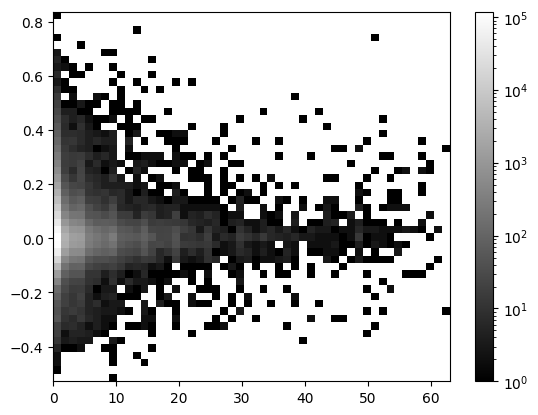

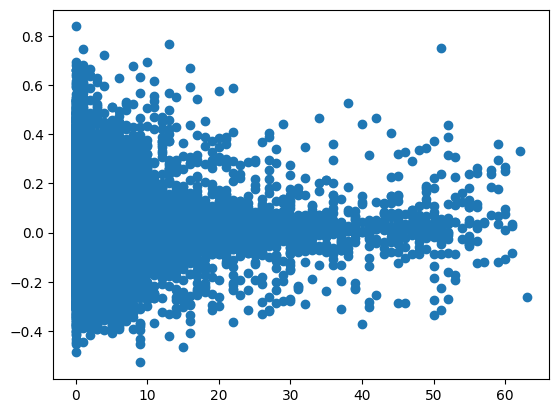

In [ ]:
par = plt.hist2d(dot_prods_features, dot_prods_resid, norm=mpl.colors.LogNorm(), cmap=mpl.cm.gray, bins=50)
plt.colorbar()
plt.show()


plt.scatter(dot_prods_features, dot_prods_resid, s=.1)
plt.show()